In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Dense, TimeDistributed, Layer
import matplotlib.pyplot as plt

In [2]:
class Sum(Layer):
    def call(self, inputs: tf.RaggedTensor) -> tf.Tensor:
        return tf.math.reduce_sum(inputs, axis=1)

In [3]:
variables = ['GenJet_pt', 'GenJet_eta', 'Jet_pt', 'Jet_genJetIdx', 'JetPFCands_pt', 'Jet_rawFactor', 
             'JetPFCands_pt', 'JetPFCands_jetIdx', 'JetPFCands_pFCandsIdx', 'PFCands_mass', 'PFCands_eta']

filepath = 'data/nano106Xv8_on_mini106X_2017_mc_NANO_py_NANO.root'

with uproot.open(filepath) as file:
    events = file['Events'].arrays(variables)

In [4]:
gen_jets = events[['GenJet_pt', 'GenJet_eta']][events.Jet_genJetIdx]
gen_jets = ak.concatenate((gen_jets[:,0], gen_jets[:,1]), axis=0)
gen_jets_df = ak.to_pandas(gen_jets)

jets = events[['Jet_pt', 'Jet_genJetIdx', 'JetPFCands_pt', 'Jet_rawFactor']]
jets = ak.concatenate((jets[:,0], jets[:,1]), axis=0)
jets_df = ak.to_pandas(jets)

main = pd.concat((jets_df, gen_jets_df), axis=1)
main

,Jet_pt,Jet_genJetIdx,JetPFCands_pt,Jet_rawFactor,GenJet_pt,GenJet_eta
entry,,,,,,
0,1681.0,1,0.613281,0.069336,1703.252563,-0.877686
1,1524.0,0,0.533203,0.055664,1426.359375,0.532349
2,1607.0,0,0.517090,0.072266,1713.849976,-0.980591
3,1676.0,0,0.911133,0.053223,1713.893799,0.559937
4,1604.0,1,0.944336,0.052734,1491.459839,0.003472
...,...,...,...,...,...,...
195,1220.0,1,1.676758,0.056641,1269.094971,0.054642
196,1225.0,1,0.514160,0.071289,1359.145874,-1.509766
197,1467.0,1,0.580566,0.059082,1471.961426,-0.739868


In [5]:
# gen_jets = events[['GenJet_pt', 'GenJet_eta']][events.Jet_genJetIdx]
# gen_jets_df = ak.to_pandas(gen_jets)
# jets = events[['Jet_pt', 'Jet_genJetIdx', 'JetPFCands_pt', 'Jet_rawFactor']]
# jets_df = ak.to_pandas(jets)
# main = pd.concat((jets_df, gen_jets_df), axis=1)
# main = pd.concat((main.groupby('entry').nth(0), main.groupby('entry').nth(1)))
# main

In [6]:
pf_cands = events[['PFCands_mass', 'PFCands_eta']][events.JetPFCands_pFCandsIdx]
pf_cands_df = ak.to_pandas(pf_cands)

jet_pf_cands = events[['JetPFCands_pt', 'JetPFCands_jetIdx', 'JetPFCands_pFCandsIdx']]
jet_pf_cands_df = ak.to_pandas(jet_pf_cands)

constituents = pd.concat((pf_cands_df, jet_pf_cands_df), axis=1)

constituents = (constituents[constituents.JetPFCands_jetIdx == 0], constituents[constituents.JetPFCands_jetIdx == 1])
outer_index = constituents[1].index.get_level_values(0) + constituents[0].index[-1][0] + 1
inner_index = constituents[1].index.get_level_values(1)
constituents[1].index = pd.MultiIndex.from_tuples(zip(outer_index, inner_index), names=('entry', 'subentry'))

constituents = pd.concat(constituents, axis=0)
constituents

PFCands_mass  PFCands_eta  JetPFCands_pt  JetPFCands_jetIdx  \
entry subentry                                                                
0     0             0.139648    -1.123291       0.613281                  0   
      1             0.139526    -0.968262       2.363281                  0   
      2             0.139526    -0.785767       6.078125                  0   
      3             0.139526    -0.830444       2.050781                  0   
      4             0.139526    -0.838135      14.437500                  0   
...                      ...          ...            ...                ...   
199   128           0.000000    -1.303223       0.651855                  1   
      129           0.000000    -1.307861       1.070312                  1   
      130          -0.000000    -1.314941       1.730469                  1   
      131           0.000000    -1.325928       0.864746                  1   
      132           0.000000    -1.336426       0.493652                  1   

                JetPFCands_pFCandsIdx  
entry subentry                         
0     0                             8  
      1                            14  
      2                            26  
      3                            30  
      4                            31  
...                               ...  
199   128                         292  
      129                         293  
      130                         294  
      131                         295  
      132                         296  

[10396 rows x 5 columns]

In [7]:
_, row_lengths = np.unique(constituents.index.get_level_values(0), return_counts=True)

In [8]:
row_lengths[:5]

array([46, 50, 54, 45, 28])

In [9]:
X = tf.RaggedTensor.from_row_lengths(constituents, row_lengths=row_lengths)

In [10]:
X.shape

TensorShape([200, None, 5])

In [11]:
y = tf.constant(ak.to_numpy(main.GenJet_pt / main.Jet_pt))

# Model

In [12]:
inputs = Input(shape=(None, 5), ragged=True, name='inputs')

inputs_slice = Input(shape=(inputs.shape[-1],), name='inputs_slice')

x = Dense(100, kernel_initializer='he_uniform', use_bias=True, name='deepset_dense')(inputs_slice)

outputs_slice = Activation('relu', name='deepset_activation')(x)

submodel_slice = Model(inputs=inputs_slice, outputs=outputs_slice, name='deepset_submodel')

outputs = TimeDistributed(submodel_slice, name='deepset_distributed')(inputs)

outputs = Sum(name='deepset_sum')(outputs)

x = Dense(100, kernel_initializer='he_uniform', use_bias=True, name='head_dense')(outputs)

x = Activation('relu', name='head_activation')(x)

outputs = Dense(1, name='head_dense_output')(x)

model = Model(inputs=inputs, outputs=outputs, name='full')

model.compile(optimizer='adam', loss='mean_absolute_error')

In [13]:
model.summary()

Model: "full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 5)]         0         
_________________________________________________________________
deepset_distributed (TimeDis (None, None, 100)         600       
_________________________________________________________________
deepset_sum (Sum)            (None, 100)               0         
_________________________________________________________________
head_dense (Dense)           (None, 100)               10100     
_________________________________________________________________
head_activation (Activation) (None, 100)               0         
_________________________________________________________________
head_dense_output (Dense)    (None, 1)                 101       
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
__________________________________________________________

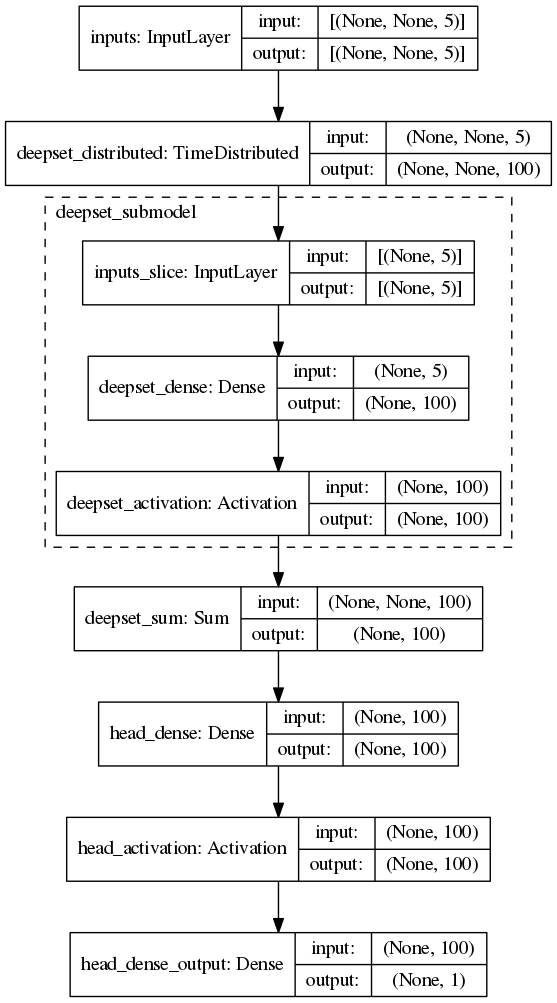

In [14]:
keras.utils.plot_model(model, 'model_full.png', dpi=100, show_shapes=True, expand_nested=True)

In [15]:
fit = model.fit(X, y, epochs=25)

Epoch 1/25
7/7 [==============================] - 1s 3ms/step - loss: 4932.2040
Epoch 2/25
7/7 [==============================] - 0s 2ms/step - loss: 1416.4710
Epoch 3/25
7/7 [==============================] - 0s 2ms/step - loss: 880.9168
Epoch 4/25
7/7 [==============================] - 0s 2ms/step - loss: 442.8138
Epoch 5/25
7/7 [==============================] - 0s 3ms/step - loss: 493.1732
Epoch 6/25
7/7 [==============================] - 0s 3ms/step - loss: 313.0785
Epoch 7/25
7/7 [==============================] - 0s 3ms/step - loss: 287.5738
Epoch 8/25
7/7 [==============================] - 0s 3ms/step - loss: 127.2202
Epoch 9/25
7/7 [==============================] - 0s 3ms/step - loss: 125.4165
Epoch 10/25
7/7 [==============================] - 0s 3ms/step - loss: 88.8655
Epoch 11/25
7/7 [==============================] - 0s 3ms/step - loss: 121.9862
Epoch 12/25
7/7 [==============================] - 0s 3ms/step - loss: 57.0434
Epoch 13/25
7/7 [==============================] 

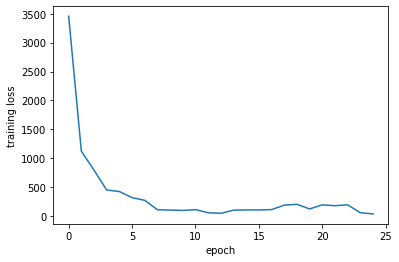

In [16]:
plt.plot(fit.history['loss'])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()